In [1]:
%reset -f

from functions import *
from preprocess_images import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from PIL import Image

from sklearn import cluster, metrics

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
from tqdm import tqdm

from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.models import Model

from keras.optimizers import SGD

In [3]:
from sklearn import manifold, decomposition

from cnn_functions import *

In [4]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

output_path = "./dataset/cleaned/"

In [5]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [6]:
data_images = pd.read_csv(input_file)
data_images.head()

,image_path,category,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# PART 1 :

In [7]:
print("TEST")
#img = Image.open(path_images + "0906fd9cc604fbba05a502e01d763cd9.jpg")

# Afficher l'image chargée
#img.show()

TEST


In [8]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [9]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,image_path,category
target,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


The data is balanced !


## Affichage d'exemples d'images par label

Home Furnishing
-------
For this category, we have 150 images.


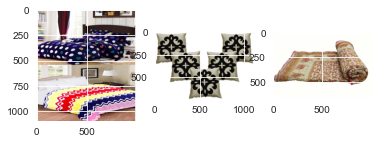

Baby Care
-------
For this category, we have 150 images.


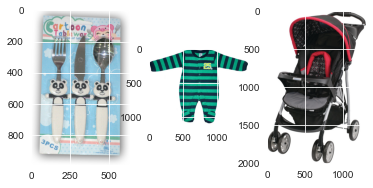

Watches
-------
For this category, we have 150 images.


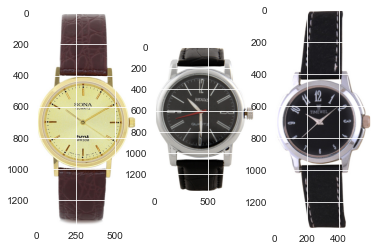

Home Decor & Festive Needs
-------
For this category, we have 150 images.


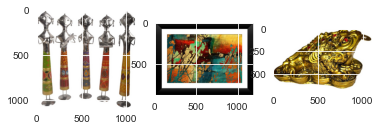

Kitchen & Dining
-------
For this category, we have 150 images.


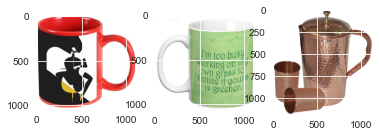

Beauty and Personal Care
-------
For this category, we have 150 images.


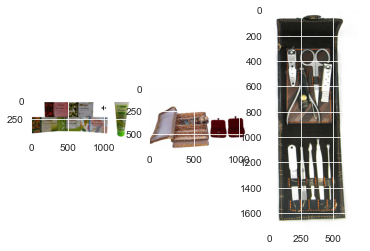

Computers
-------
For this category, we have 150 images.


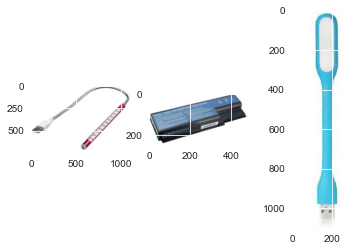

In [10]:
n_categories = len(list_labels)
n_photos = len(list_photos)

display_images_per_category(list_labels, data_images, path_images, "image_path", "category", list_photos)

In [11]:
data_images.target

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: target, Length: 1050, dtype: int64

# PART 2 : CNN and Transfert Learning

## 1) CNN

In [12]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Afficher l'image chargée
img.show()

In [13]:
filename

'./dataset/images/009099b1f6e1e8f893ec29a7023153c4.jpg'

In [14]:
data_images[data_images["image_path"] == list_photos[0]]

,image_path,category,target
280,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6


#### Functions

In [15]:
mapper = data_images[["category", "target"]].drop_duplicates().sort_values(by="target").reset_index(drop=True)
mapper

,category,target
0,Baby Care,0
1,Beauty and Personal Care,1
2,Computers,2
3,Home Decor & Festive Needs,3
4,Home Furnishing,4
5,Kitchen & Dining,5
6,Watches,6


In [16]:
mapping_categories = {row["target"]: row["category"] for i, row in mapper.iterrows()}
mapping_categories

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

#### End of functions

#### 0) Pre-Trained Model as Classifier


In [17]:
image = prepare_image_as_input(list_photos[0], path_images)

In [18]:
# load the model
vgg = VGG16()  # Création du modèle VGG-16 implementé par Keras

In [19]:
# predict the probability across all output classes # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
y = vgg.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y)
# retrieve the most likely result, e.g. highest probability

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 [==============================] - 1s 865ms/step
Top 3 : [('n03706229', 'magnetic_compass', 0.40458965), ('n02708093', 'analog_clock', 0.21896486), ('n03314780', 'face_powder', 0.05964659)]
magnetic_compass (40.46%)


## 2) Transfert Learning

### 1) Stratégie 2 : extraction des features / Feature Extractor Preprocessor

In [20]:
# example of using the vgg16 model as a feature extraction model

In [21]:
def build_vgg_features():
    # load model
    vgg = VGG16()
    # remove the output layer
    vgg_features_model = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
    return vgg_features_model

In [22]:
vgg_features_model = build_vgg_features()
vgg_features_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
print("TEST")
image = prepare_image_as_input(list_photos[0], path_images)
# get extracted features
features = vgg_features_model.predict(image)
print(features.shape)
# save to file
#dump(features, open('dog.pkl', 'wb'))

TEST
1/1 [==============================] - 1s 685ms/step
(1, 4096)


In [24]:
features

array([[2.5928054 , 2.6987507 , 0.        , ..., 0.87792766, 0.        ,
        2.9672122 ]], dtype=float32)

#### Making features for all the images

vgg_features_by_img, vgg_features_all = get_features(data_images, "image_path", path_images, vgg_features_model)
save_features("dataset/", "vgg_features_by_img.npz", vgg_features_by_img)
save_features("dataset/", "vgg_features_all.npz", vgg_features_all)

In [25]:
vgg_features_by_img = load_features("dataset/", "vgg_features_by_img.npz")
vgg_features_all = load_features("dataset/", "vgg_features_all.npz")

In [26]:
vgg_features_all

array([[3.3986163 , 0.8595742 , 0.        , ..., 0.        , 0.85105604,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.2971013 , 0.        ,
        0.        ],
       ...,
       [2.1961308 , 2.3982728 , 2.6236415 , ..., 2.1598763 , 0.1847224 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24832901,
        0.9251385 ],
       [0.        , 0.        , 0.12313145, ..., 0.        , 0.527719  ,
        2.9917479 ]], dtype=float32)

### Visualizing PCA / t-SNE

In [27]:
feat_pca = get_pca_for_features(vgg_features_all)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA avec 99% variance expliquée:  (1050, 803)


In [28]:
X_tsne, df_tsne = get_tsne(feat_pca, data_images, "category")

(1050, 3)


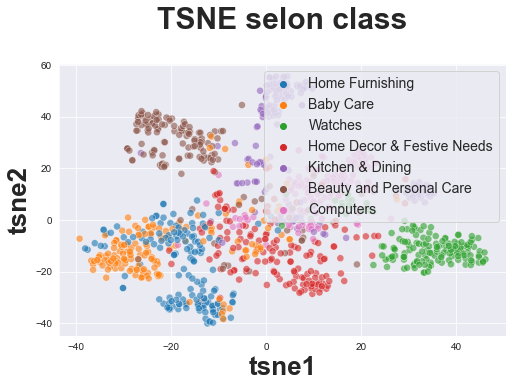

In [29]:
display_tsne(df_tsne, "class")

#### Clustering

In [30]:
cls = clustering_tsne(X_tsne)
df_tsne = add_cluster_tsne(df_tsne, cls)

(1050, 4)


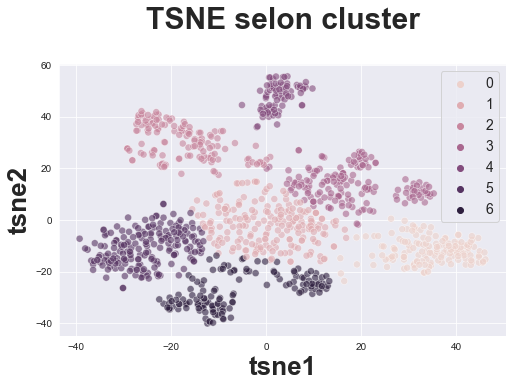

ARI :  0.4328268551209832


In [31]:
display_tsne(df_tsne, "cluster")
print_ari_score(labels=data_images["target"], cls=cls)

In [32]:
data_images

X = data_images["image_path"]
y = data_images["target"]

X.shape
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#### 2) Pre-Trained Model as Feature Extractor in Model

# load model without classifier layers
model = VGG16()

# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
    layer.trainable = False

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(7, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# summarize
model.summary()

In [36]:
prepare_image_as_input(list_photos[0], path_images)

array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [37]:
X_train.index

Int64Index([ 281,  266,  534,  453,  359,  490,  991,  816,  118,  634,
            ...
             343,  769,  130,  871,   87,  330,  466,  121, 1044,  860],
           dtype='int64', length=735)

In [38]:
X_train

281     db3e2eeb4fe90d4755f2911d661eae95.jpg
266     0e73201f6d8807776e1d21c969078289.jpg
534     4019ad332ca3ce22449ff54fdd49a273.jpg
453     e6b483fce5fd910afda67d97dc04e775.jpg
359     4b0e6f200426b1db8824b2ca0c59ecfa.jpg
                        ...                 
330     394c2c627914e1eed9b8ac343583a679.jpg
466     3bc98543c7dd0d8fce5b8185b4a58c43.jpg
121     7dd5e83e2108a97659577e50879f9d9f.jpg
1044    be0f39341d771aac57084970f1ed6425.jpg
860     6136976dc5a433cdf8e2559b8510bdce.jpg
Name: image_path, Length: 735, dtype: object

In [39]:
X_train.at[991]

'06fdaa2b03d70da4358311d260456729.jpg'

In [40]:
all_images = []
for index in tqdm(X_train.index):
    img = prepare_image_as_input(X_train.at[index], path_images)
    all_images.append(img[0]) #

X_train_input = np.asarray(all_images)


100%|██████████| 735/735 [00:18<00:00, 40.13it/s]


In [41]:
X_train_input[0].shape

(224, 224, 3)

In [42]:
X_train_input.shape

(735, 224, 224, 3)

In [43]:
from keras.utils import to_categorical
#one-hot encode target column
y_train_input = to_categorical(y_train)
y_test_input = to_categorical(y_test)
y_train_input[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model.fit(X_train_input, y_train_input, epochs=3, verbose=2)

#### trying : not working

df_cnn = data_images.copy()
df_cnn["prediction_category"] = -1

for index, row in tqdm(df_cnn.iterrows(), total=df_cnn.shape[0]):
    #print("Step :", index)
    img = df_cnn.at[index, "image_path"]
    #print(img)
    result = predict_category(img, path_images, model, mapping_categories)
    df_cnn.at[index, "prediction_category"] = result[0]

df_cnn.to_csv("dataset/df_cnn.csv")

In [ ]:
df_cnn = pd.read_csv("dataset/df_cnn.csv")

In [ ]:
df_cnn["prediction_category"].value_counts().plot(kind='pie')

In [ ]:
list_labels

for label in mapping_categories:
    print(mapping_categories[label])

In [ ]:
conf_mat = metrics.confusion_matrix(y_true=df_cnn["target"], y_pred=df_cnn["prediction_category"])
print(conf_mat)

In [ ]:
df_cm = pd.DataFrame(conf_mat, index=[mapping_categories[label] for label in mapping_categories.keys()],
                     columns=[str(label) for label in mapping_categories])

plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

In [ ]:
print("ARI : ", metrics.adjusted_rand_score(df_cnn["target"], df_cnn["prediction_category"]))

In [ ]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))